# Proyecto Control Optimo
## Resonancia Magnetica

Diego Echeverria
Luciano Ragebait


In [1]:
import Pkg
Pkg.add("JuMP")
Pkg.add("Ipopt")
Pkg.add("Plots")
Pkg.add("OptimalControl")
Pkg.add("DifferentialEquations")

   Resolving package versions...
  No Changes to `C:\Users\Diego\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Diego\.julia\environments\v1.11\Manifest.toml`
Precompiling project...
           ✗ BARON
  0 dependencies successfully precompiled in 9 seconds. 570 already precompiled.

The following 1 direct dependency failed to precompile:

BARON 

Failed to precompile BARON [2e2ca445-9e14-5b13-8677-4410f177f82b] to "C:\\Users\\Diego\\.julia\\compiled\\v1.11\\BARON\\jl_E4D7.tmp".
ERROR: LoadError: SystemError: opening file "C:\\Users\\Diego\\.julia\\packages\\BARON\\rvhNu\\deps\\path.jl": No such file or directory
Stacktrace:
  [1] systemerror(p::String, errno::Int32; extrainfo::Nothing)
    @ Base .\error.jl:176
  [2] systemerror
    @ .\error.jl:175 [inlined]
  [3] open(fname::String; lock::Bool, read::Bool, write::Nothing, create::Nothing, truncate::Nothing, append::Nothing)
    @ Base .\iostream.jl:295
  [4] open
    @ .\iostream.jl:277 [inlined]
  [5] open(fname::

Para Partir
Tenemos dos vectores metidos en la bola
el control esta en la bola
cada vector tiene hiperparametros distintos
el control se mueve inponiendo que q1 termine en el 0


$$  
    max \space |q_2(t_f)|^2
$$
$$
 \dot q = F(q,u)
$$
$$
    |u(-)| \leq 1
$$
$$
q_1(0) = q_2(0) = (0,1)
$$
$$
q_1(t_f) = (0,0)
$$

In [2]:
using JuMP
import Ipopt
using Plots
using LinearAlgebra

# Modelacion JuMP con EULER
function Euler_magnetic(N,v1,v2,tf,q10,q20)

    # N: Numero de pasos
    # v1: Hiperparametros de q1  ( es q)
    # v2: Hiperparametros de q2 ( es r) 
    # tf: tiempo final escogido ( múltiplo de tiempo minimo de convergencia de q1)
    model = JuMP.Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, q[1:2,1:N+1]) # variable q1
    @variable(model, r[1:2,1:N+1]) # variable q2
    @variable(model, 1 >= u[1:N+1] >= -1) # el control 

    y10,z10 = q10
    y20,z20 = q20
    
    @constraint(model, q[:,1] == [y10,z10]) # cond ini q1
    @constraint(model, r[:,1] == [y20,z20]) # cond ini q2

    @constraint(model, q[: ,N+1] == [0,0]) # cond final de q1

    sigma1, gamma1 = v1
    sigma2, gamma2 = v2

    A1 = [-sigma1 0 ; 0 -gamma1]
    C1 = [0 , gamma1]
    @constraint(model, [i = 1:N], q[:,i+1] == q[:,i] + (tf/N) .* (A1*q[:,1] + [ -q[2,i]*u[i] , q[1,i]*u[i] ] + C1)) # paso de q1

    A2 = [-sigma2 0 ; 0 -gamma2]
    C2 = [0 , gamma2]
    @constraint(model, [i = 1:N], r[:,i+1] == r[:,i] + (tf/N) .* (A2*r[:,1] +[ -r[2,i]*u[i] , r[1,i]*u[i] ] + C2)) # paso de q2

    @objective(model, Max, sum(r[:,N+1].^2) )
    optimize!(model);

    println("Valor final en norma: ", string( sum(value(r[:,N+1]).^2) ))
    u = [value(u[i]) for i in 1:N+1]
    q1 =[value(q[:,i]) for i in 1:N+1]
    q2 =[value(r[:,i]) for i in 1:N+1]
    t = range(0,tf, N+1)

end
    

Euler_magnetic (generic function with 1 method)

In [19]:
using OptimalControl
using NLPModelsIpopt

# busco el tiempo minimo de convergencia de q1 para tener el rango de tiempo del problema completo
function find_tmin(v1,q0)
    

sigma1, gamma1 = v1
y0,z0 = q0
OCP = @def begin
        tf ∈ R, variable
        t ∈ [0,tf], time
        q1 = (y,z) ∈ R^2, state
        u ∈ R, control

        # restricciones tiempo y control
        tf >= 0.001 # pa que no de negativo
        -1 <= u(t) <= 1

        # condiciones iniciales
        y(0) == y0
        z(0) == z0

        # condiciones finales
        y(tf) == 0
        z(tf) == 0

        # ecuaciones 
        ∂(y)(t) == -sigma1*y(t) -u(t)*z(t)
        ∂(z)(t) == gamma1*(1-z(t)) + u(t)*y(t)

        tf → min

    end

    sol_ocp = solve(OCP, display=false)
    println("Tiempo optimo: ", sol_ocp.objective)
    plot(sol_ocp,plot_title = "Control y trayectoria optima de la particula" )

    return sol_ocp.objective
end 

find_tmin (generic function with 1 method)

In [4]:
v1 = [ 1/0.3, 1/2 ]
v2 = [ 1/2.5, 1/2.5]

q01 = [0.5,0.5]

# tiempo
tf = find_tmin(v1,q01)

print(tf)
N = 100
# debo escoger un multiplo del tiempo
Euler_magnetic(N,v1,v2,10*tf,q01,q01)


Tiempo optimo: 0.8178531423147481
0.8178531423147481Valor final en norma: 0.7347118868650582


0.0:0.08178531423147481:8.178531423147481

In [5]:
using OptimalControl
using NLPModelsIpopt
using Plots

# Misma modelacion pero en OptimalControl 
function OC_Magnetic(v1,v2,tf,q10,q20)

sigma1, gamma1 = v1
sigma2, gamma2 = v2
y10,z10  = q10
y20,z20 = q20

OCP = @def begin
        t ∈ [0,tf], time
        q = (y1,z1,y2,z2) ∈ R^4, state
        u ∈ R, control



        0 <= u(t) <= 1

        # condiciones iniciales
        y1(0) == y10
        z1(0) == z10
        y2(0) == y20
        z2(0) == z20

        # condiciones finales
        y1(tf) == 0.0
        z1(tf) == 0.0

        # ecuaciones 
        ∂(y1)(t) == -sigma1*y1(t) -u(t)*z1(t)
        ∂(z1)(t) == gamma1*(1-z1(t)) + u(t)*y1(t)
        
        ∂(y2)(t) == -sigma2*y2(t) -u(t)*z2(t)
        ∂(z2)(t) == gamma2*(1-z2(t)) + u(t)*y2(t)

        y2(tf)^2 + z2(tf)^2  → max

        
     end

    sol_ocp = solve(OCP, display=false)
    println("Tiempo optimo: ", sol_ocp.objective)
    plot(sol_ocp,plot_title = "Control y trayectoria optima de la particula" )
     println("Valor máximo de ||q2||: ", sqrt(sol_ocp.objective))

    step = tf/100
    time_grid = 0.0:step:tf # Example time grid
    qq = state(sol_ocp)
  

    y1_data = [qq(t)[1] for t in time_grid]
    z1_data = [qq(t)[2] for t in time_grid]
    y2_data = [qq(t)[3] for t in time_grid]
    z2_data = [qq(t)[4] for t in time_grid]

    print( qq(tf), "Valores Finales")

# --- Creación del Gráfico Combinado ---
    
    # --- Gráfico 1: Trayectoria de q1 (con flechas) ---
    plot_q1 = plot(
        xlabel="y (Plano Transversal)", 
        ylabel="z (Plano Longitudinal)",
        title="Trayectoria de q1 (Tejido 1)",
        legend=:topleft,
        aspect_ratio=:equal
    )

    # Añadir trayectoria de q1 con FLECHAS
    plot!(plot_q1, y1_data, z1_data, 
        label="q1", 
        lw=2, 
        color=:blue,
    )

    # Marcar puntos de q1
    scatter!(plot_q1, [y1_data[1]], [z1_data[1]], 
        label="Inicio", color=:green, markersize=5)
    scatter!(plot_q1, [y1_data[end]], [z1_data[end]], 
        label="Fin q1 (0,0)", color=:blue, marker=:x, markersize=5,arrow=true)


    plot_q2 = plot(
        xlabel="y (Plano Transversal)", 
        ylabel="z (Plano Longitudinal)",
        title="Trayectoria de q2 (Tejido 2)",
        legend=:topleft,
        aspect_ratio=:equal
    )

    # Añadir trayectoria de q2 con FLECHAS
    plot!(plot_q2, y2_data, z2_data, 
        label="q2", 
        lw=2, 
        color=:red
    )

    # Marcar puntos de q2
    scatter!(plot_q2, [y2_data[1]], [z2_data[1]], 
        label="Inicio", color=:green, markersize=5)
    scatter!(plot_q2, [y2_data[end]], [z2_data[end]], 
        label="Fin q2 (Max)", color=:red, marker=:star, markersize=5)

    # --- Gráfico 1: Control (AÑADIDO) ---
    plot_control = plot(sol_ocp, :control, 
        title="Control Óptimo u(t)", 
        label="u(t)", 
        lw=2
    )

    # --- Combinar y Mostrar ---
    # Crea un gráfico final con los dos sub-gráficos
    combined_plot = plot(plot_q1, plot_q2, layout=(1,2), size=(800, 500))
    
    display(combined_plot)

    display(plot_control)
    #savefig(combined_plot, "trayectorias_separadas_con_flechas.png")
    savefig(plot_control, "control_óptimo.png")
    println("Gráfico combinado guardado como 'trayectorias_separadas_con_flechas.png'")

end

        

OC_Magnetic (generic function with 1 method)

Tiempo optimo: 0.0009999916853262437
0.0019999833706524873Tiempo optimo: 0.999999999997017
Valor máximo de ||q2||: 0.9999999999985085
[-7.324874592996607e-12, 1.7406616505233512e-8, -0.0006797571503085786, 0.9999997689635901]Valores FinalesGráfico combinado guardado como 'trayectorias_separadas_con_flechas.png'


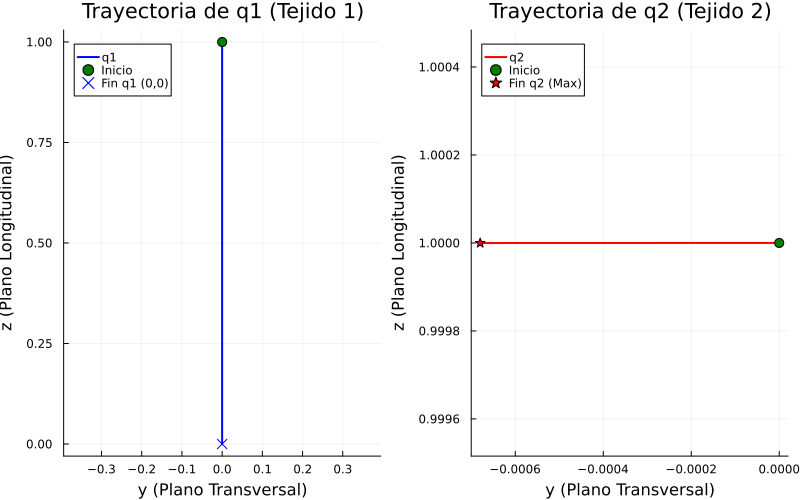

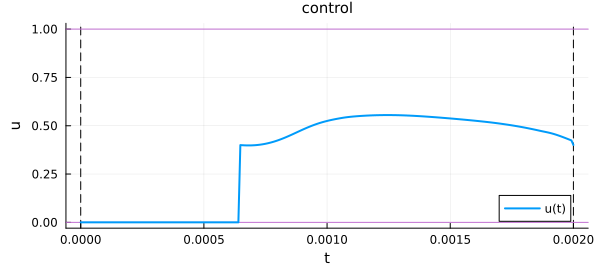

In [ ]:
w = 2*pi
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] # esto quizas falta un 2pi

q10 = [0,1]

tf = find_tmin(v1,q10)
tf = 2*tf
print(tf)
OC_Magnetic(v1,v2,tf,q10,q10)

In [7]:
# Modelacion JuMP con EULER
function Euler_magnetic3D(N,v1,v2,tf)

    # N: Numero de pasos
    # v1: Hiperparametros de q1  ( es q)
    # v2: Hiperparametros de q2 ( es r) 
    # tf: tiempo final escogido ( múltiplo de tiempo minimo de convergencia de q1)
    model = JuMP.Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, q[1:3,1:N+1]) # variable q1 (x,y,z)
    @variable(model, r[1:3,1:N+1]) # variable q2 (x,y,z)
    @variable(model, 1 >= u[1:2,1:N+1] >= -1) # el control 
    
    @constraint(model, q[:,1] == [0,0,1]) # cond ini q1
    @constraint(model, r[:,1] == [0,0,1]) # cond ini q2

    @constraint(model, q[: ,N+1] == [0,0,0]) # cond final de q1

    @constraint(model, [i = 1:N], u[1,i]^2+u[2,i]^2 <= 1 ) # control en bola unitaria

    sigma1, gamma1 = v1
    sigma2, gamma2 = v2

    A1 = [-sigma1 0 0; 0 -sigma1 0 ; 0 0 -gamma1]
    C1 = [0, 0 , gamma1]
    @constraint(model, [i = 1:N], q[:,i+1] == q[:,i] + (tf/N) .* (A1*q[:,1] + [ q[3,i]*u[2,i], -q[3,i]*u[1,i] , q[2,i]*u[1,i] - q[1,i]*u[2,i] ] + C1)) # paso de q1

    A2 = [-sigma2 0 0; 0 -sigma2 0 ; 0 0 -gamma2]
    C2 = [0 ,0, gamma2]
    @constraint(model, [i = 1:N], r[:,i+1] == r[:,i] + (tf/N) .* (A2*r[:,1] + [ r[3,i]*u[2,i], -r[3,i]*u[1,i] , r[2,i]*u[1,i] - r[1,i]*u[2,i] ] + C2)) # paso de q2

    @objective(model, Max, sum(r[:,N+1].^2) )
    optimize!(model);

    println("Valor final en norma: ", string( sum(value(r[:,N+1]).^2) ))
    # u = [value(u[i]) for i in 1:N+1]
    # q1 =[value(q[:,i]) for i in 1:N+1]
    # q2 =[value(r[:,i]) for i in 1:N+1]
    # t = range(0,tf, N+1)

end

Euler_magnetic3D (generic function with 1 method)

In [13]:
using OptimalControl
using NLPModelsIpopt

# busco el tiempo minimo de convergencia de q1 para tener el rango de tiempo del problema completo
function find_tmin3D(v1)
    

sigma1, gamma1 = v1
OCP = @def begin
        tf ∈ R, variable
        t ∈ [0,tf], time
        q1 = (x,y,z) ∈ R^3, state
        u = (u1,u2) ∈ R^2, control

        # restricciones tiempo y control
        tf >= 0.001 # pa que no de negativo
        0 <= sum(u1(t)^2 + u2(t)^2) <= 1
        0 <= sum(x(t)^2 + y(t)^2 + z(t)^2) <= 1

        # condiciones iniciales
        x(0) == 0
        y(0) == 0
        z(0) == 1

        # condiciones finales
        x(tf) == 0
        y(tf) == 0
        z(tf) == 0
        

        # ecuaciones
        ∂(x)(t) == -sigma1*x(t) - u2(t)*z(t)
        ∂(y)(t) == -sigma1*y(t) -u1(t)*z(t)
        ∂(z)(t) == gamma1*(1-z(t)) + u1(t)*y(t) - u2(t)*x(t)

        tf → min

    end

    sol_ocp = solve(OCP, display=false)
    println("Tiempo optimo: ", sol_ocp.objective)
    plot(sol_ocp,plot_title = "Control y trayectoria optima de la particula" )

    return sol_ocp.objective
end 

find_tmin3D (generic function with 1 method)

In [15]:
using OptimalControl
using NLPModelsIpopt
using Plots
# Misma modelacion pero en OptimalControl 
function OC_Magnetic3D(v1,v2,tf)

sigma1, gamma1 = v1
sigma2, gamma2 = v2

OCP = @def begin
        t ∈ [0,tf], time
        q = (x1,y1,z1,x2,y2,z2) ∈ R^6, state
        u = (u1,u2) ∈ R^2, control


        # restricciones tiempo y control
        tf >= 0.00001 # pa que no de negativo
        0 <= sum(u1(t)^2 + u2(t)^2) <= 1

        0 <= sum(x1(t)^2 + y1(t)^2 + z1(t)^2) <= 1
        0 <= sum(x2(t)^2 + y2(t)^2 + z2(t)^2) <= 1

        # condiciones iniciales
        x1(0) == 0
        y1(0) == 0
        z1(0) == 1

        x2(0) == 0
        y2(0) == 0
        z2(0) == 1

        # condiciones finales
        x1(tf) == 0
        y1(tf) == 0
        z1(tf) == 0

        # ecuaciones
        ∂(x1)(t) == -sigma1*x1(t) - u2(t)*z1(t)
        ∂(y1)(t) == -sigma1*y1(t) -u1(t)*z1(t)
        ∂(z1)(t) == gamma1*(1-z1(t)) + u1(t)*y1(t) - u2(t)*x1(t)
        
        ∂(x2)(t) == -sigma2*x2(t) - u2(t)*z2(t)
        ∂(y2)(t) == -sigma2*y2(t) -u1(t)*z2(t)
        ∂(z2)(t) == gamma2*(1-z2(t)) + u1(t)*y2(t) - u2(t)*x2(t)

        x2(tf)^2 + y2(tf)^2 + z2(tf)^2  → max

        
     end

    sol_ocp = solve(OCP, display=false)
     println("Valor máximo de ||q2||: ", sqrt(sol_ocp.objective))

    step = tf/100
    time_grid = 0.0:step:tf # Example time grid
    qq = state(sol_ocp)
  

    x1_data = [qq(t)[1] for t in time_grid]
    y1_data = [qq(t)[2] for t in time_grid]
    z1_data = [qq(t)[3] for t in time_grid]
    x2_data = [qq(t)[4] for t in time_grid]
    y2_data = [qq(t)[5] for t in time_grid]
    z2_data = [qq(t)[6] for t in time_grid]

    print( qq(tf), "Valores Finales")

# 1. Gráfico 3D para q1 (Tejido 1 - Saturación)
    p1 = plot(x1_data, y1_data, z1_data,
        label="Trayectoria q1",
        xlabel="x", ylabel="y", zlabel="z",
        title="Dinámica q1 (Saturación)",
        lw=2, color=:blue,
        camera=(45, 30) # Ángulo de cámara para ver profundidad
    )
    # Marcar inicio (verde) y fin (azul X)
    scatter!(p1, [x1_data[1]], [y1_data[1]], [z1_data[1]], color=:green, label="Inicio")
    scatter!(p1, [x1_data[end]], [y1_data[end]], [z1_data[end]], color=:blue, shape=:cross, markersize=6, label="Fin (0,0,0)")

    # 2. Gráfico 3D para q2 (Tejido 2 - Maximización)
    p2 = plot(x2_data, y2_data, z2_data,
        label="Trayectoria q2",
        xlabel="x", ylabel="y", zlabel="z",
        title="Dinámica q2 (Contraste)",
        lw=2, color=:red,
        camera=(45, 30)
    )
    # Marcar inicio (verde) y fin (estrella roja)
    scatter!(p2, [x2_data[1]], [y2_data[1]], [z2_data[1]], color=:green, label="Inicio")
    scatter!(p2, [x2_data[end]], [y2_data[end]], [z2_data[end]], color=:red, shape=:star, markersize=6, label="Fin (Max)")

    # 3. Gráfico de Controles
    # OptimalControl.jl permite plotear directamente la solución del control
    p3 = plot(sol_ocp, :control, title="Controles Óptimos (u1, u2)")

    # --- Combinar y Guardar ---
    # Layout: Arriba los dos 3D, abajo los controles
    l = @layout [a b; c]
    combined_plot = plot(p1, p2, p3, layout=l, size=(900, 800))

    display(combined_plot)
    savefig(combined_plot, "trayectorias_3d_magnetica.png")
    println("Gráfico 3D guardado como 'trayectorias_3d_magnetica.png'")

    end

        

OC_Magnetic3D (generic function with 1 method)

In [ ]:
w = 2*pi
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] # esto quizas falta un 2pi


# tiempo
tf = find_tmin3D(v1)

print(tf)
N = 100
# debo escoger un multiplo del tiempo
Euler_magnetic3D(N,v1,v2,10*tf)


Tiempo optimo: 155.55013067964626
155.55013067964626Valor final en norma: 

Tiempo optimo: 129.69968516039978
129.69968516039978Valor máximo de ||q2||: 1.000000004994779
[-2.3567153622948395e-35, 1.215663939561368e-32, 2.4051808261337436e-34, 0.6366335365855353, -0.22934730787226962, -0.7362727500430085]Valores FinalesGráfico 3D guardado como 'trayectorias_3d_magnetica.png'


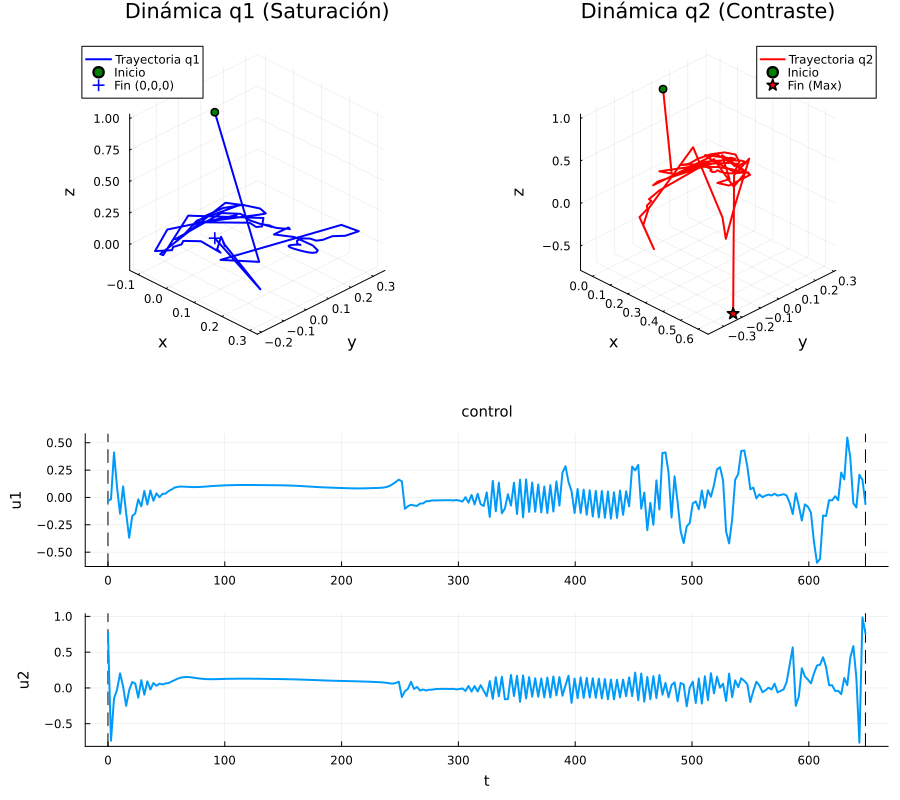

In [16]:
w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] # esto quizas falta un 2pi

tf = find_tmin3D(v1)

print(tf)
OC_Magnetic3D(v1,v2,5*tf)

# Debido a la ecuación no lineal de la función objectivo (problema de mayer) se va a hacer la función P


$$
g(q(t_f)) = |q_2(t_f)|^2
$$

$$
H(q,u,\lambda) = \lambda^T F(q,u)
$$

$$
H(t,x,p(t),u(t)) = p(t)^T F(x(t),u(t)) \\
= p_{y_1}(t) (\Gamma_{1} y_1(t) - u z_1(t)) + p_{z_1}(t) (\gamma_{1} (1-z_1(t)) + u y_1(t)) \\
+ p_{y_2}(t) (\Gamma_{2} y_2(t) - u z_2(t)) + p_{z_2}(t) (\gamma_{2}(1-z_2(t)) + u y_2(t))  
$$


Veamos las condiciones de transversalidad

$$
0 = p_0 dg + [\theta(t)dt - p(t)^T dx_t]_{dt_0}^{dt_f} 
$$

Veamos que variable son libres y cuales no
- t0 fijo = 0
- tf es fijo = $\lambda T_{min}$
- x0 fijo = $(0,1,0,1)$
- xf libre $(0,0,y_2(t_f),z_2(t_f))$

Con esto dg es 
$$
dg = [0,0,0,2y_2(t_f)+2z_2(t_f)]^T
$$

In [12]:
function optimal_u(t,q,p)
    u = -p[1]*q[2] + p[2]*q[1] - p[3]*q[4]  + p[4]*q[3]
    return u
end

optimal_u (generic function with 1 method)

In [13]:
# cons = [gamma1, sigma1, gamma2, sigma2]
function system_acoplado!(t,q,p,cons)
    u = optimal_u(t,q,p)

    gamma1, sigma1, gamma2, sigma2 = cons

    dq = [0,0,0,0]
    dp = [0,0,0,0]
    dq[1] = -gamma1*q[1] - u*q[2]
    dq[2] = sigma1*(1-q[2]) + u*q[1]
    dq[3] = -gamma2*q[3] - u*q[4]
    dq[4] = sigma2*(1-q[4]) + u*q[3]
    
    dp[1] = gamma1*p[1] - u*p[2]
    dp[2] = p[2]*sigma1 + u*p[1]
    dp[3] = gamma2*p[3] - u*p[4]
    dp[4] = +p[4]*sigma2 + u*p[3]

    return dq, dp
end

system_acoplado! (generic function with 1 method)

In [ ]:
using JuMP
using Ipopt
import DifferentialEquations as DE
using LinearAlgebra
using Plots
using NLsolve 

# # --- FUNCIÓN 1: optimal_u (Tu código) ---
function optimal_u(t,p,q)
    cosa = -p[1]*q[2] + p[2]*q[1] - p[3]*q[4]  + p[4]*q[3]
    if cosa > 0
        u = 1
    else
        u = 0
    end
    return u
end


function system_acoplado!(t, p, q, cons)
    u = optimal_u(t, p, q) 
    gamma1, sigma1, gamma2, sigma2 = cons 

    T = eltype(q) 
    dq = zeros(T, 4)
    dp = zeros(T, 4)
    
    dq[1] = -gamma1*q[1] - u*q[2]
    dq[2] = +sigma1*(1-q[2]) + u*q[1] 
    dq[3] = -gamma2*q[3] - u*q[4]
    dq[4] = +sigma2*(1-q[4]) + u*q[3] 
    
    dp[1] = gamma1*p[1] - u*p[2]
    dp[2] = p[2]*sigma1 + u*p[1]

    dp[3] = gamma2*p[3] - u*p[4]
    dp[4] = p[4]*sigma2 + u*p[3]

    return dq, dp
end

# --- FUNCIÓN 3: EDO! (Tu código) ---
function EDO!(du, u, p, t)
    dq, dp = system_acoplado!(t, u[5:8], u[1:4], p) 
    
    du[1] = dq[1]
    du[2] = dq[2]
    du[3] = dq[3]
    du[4] = dq[4]

    du[5] = dp[1]
    du[6] = dp[2]
    du[7] = dp[3]
    du[8] = dp[4]
end

# --- FUNCIÓN 4 (Desglosada para JuMP) ---
# Necesitamos registrar 4 funciones separadas, una para cada condición

# Función auxiliar (¡ineficiente, pero necesaria para este enfoque!)
function solve_and_get_solution(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    cons = [c1, c2, c3, c4]
    p_guess = [p1, p2, p3, p4]
    T = eltype(p_guess)
    tspan = (0.0, tf) 
    u0 = [T(0.0), T(1.0), T(0.0), T(1.0), p1, p2, p3, p4] 
    prob = DE.ODEProblem(EDO!, u0, tspan, cons) 
    sol = DE.solve(prob, DE.Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep=false)
    return sol
end

# Las 4 funciones de restricción
function get_cond1(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    sol = solve_and_get_solution(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    return sol[1,end] # y_1(tf)
end
function get_cond2(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    sol = solve_and_get_solution(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    return sol[2,end] # z_1(tf)
end
# function get_cond3(p1, p2, p3, p4, tf, c1, c2, c3, c4)
#     sol = solve_and_get_solution(p1, p2, p3, p4, tf, c1, c2, c3, c4)
#     return sol[7,end]*sol[4,end] - sol[8,end]*sol[3,end] # paralelo
# end



function Shooting3(tf, cons)

    model = JuMP.Model(Ipopt.Optimizer)
    # set_silent(model)
    
    @variable(model, p[1:4])
    set_start_value.(p, [0.1,0.1,0.1,0.1])


    set_optimizer_attribute(model, "acceptable_tol", 1e-6)
    set_optimizer_attribute(model, "acceptable_iter", 5) # Intenta aceptar después de 5 iter

    # Relaja la tolerancia de violación de restricciones (aunque aquí no hay)
    set_optimizer_attribute(model, "constr_viol_tol", 1e-4)

    # Registrar las 4 funciones de restricción
    args = (p[1], p[2], p[3], p[4], tf, cons[1], cons[2], cons[3], cons[4])
    register(model, :get_cond1, 9, get_cond1, autodiff=true)
    register(model, :get_cond2, 9, get_cond2, autodiff=true)
    register(model, :get_cond3, 9, get_cond3, autodiff=true)
    #register(model, :get_cond4, 9, get_cond4, autodiff=true)
    
    # Definir las RESTRICCIONES (deben ser == 0)
    @NLconstraint(model, c1, get_cond1(args...) == 0.0)
    @NLconstraint(model, c2, get_cond2(args...) == 0.0)
    #@NLconstraint(model, c3, get_cond3(args...) == 0.0)
    #@NLconstraint(model, c4, get_cond4(args...) == 0.0)

    # El objetivo es irrelevante, solo queremos encontrar un punto factible
    @NLobjective(model, Min, get_cond3(args...))

    optimize!(model)
    
    
    if JuMP.termination_status(model) != MOI.SUCCESS
        println("El método de tiro (NLsolve) NO convergió.")
    else
        println("¡NLsolve convergió exitosamente!")
    end
    p_opt = nlsolve_result.zero # La raíz encontrada es p_opt
    println("  p_opt(s) = ", p_opt)
    
    final_error = zeros(4)
    calculate_error_vector!(final_error, p_opt, tf, cons)
    println("  Norma del error final: ", norm(final_error))
        
    return p_opt
end


Shooting3 (generic function with 1 method)

In [21]:
w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] 
cons = [v1[1], v1[2], v2[1], v2[2]]

q01 = [0.0,1.0]

tf = find_tmin(v1,q01)

println(tf)
lambda = 1000
tf_final = lambda * tf
p_guess_inicial = [0.01, 0.01, 1, 1]

# Llamamos a la nueva función (rápida)
p_otp = Shooting3(tf_final, cons)

if p_otp !== nothing
    tspan = (0.0, tf_final)
    u0 = [0.0, 1.0, 0.0, 1.0, p_otp[1],p_otp[2],p_otp[3],p_otp[4]] # Usamos p_otp
    prob = DE.ODEProblem(EDO!, u0, tspan, cons)
    
    # save_everystep=true para poder verificar el estado final
    sol_final = DE.solve(prob, DE.Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep=true) 

    final_states = sol_final.u[end] 
    final_q = final_states[1:4]
    final_p = final_states[5:8]

    println("---- ESTADOS DE Q ...........")
    println("q1: ", final_q)
    println("---------- VALOR FINAL -------")
    println(norm([final_q[3],final_q[4]]))

    println("--- Verificación de Restricciones ---")
    println("q1(tf) = (", final_q[1], ", ", final_q[2], ") <-- Debería ser (0, 0)")
    
    err_paralelo = final_p[3]*final_q[4] - final_p[4]*final_q[3]
    println("Error Paralelismo: ", err_paralelo, " <-- Debería ser 0")
    
    err_norma = final_p[3]^2 + final_p[4]^2 - 1.0
    println("Error Norma: ", err_norma, " <-- Debería ser 0")
else
    println("No se pudo")
end

Tiempo optimo: 0.0009999916853262437
0.0009999916853262437


┌ Warning: dt(Dual{ForwardDiff.Tag{MathOptInterface.Nonlinear.var"#15#16"{typeof(get_cond1)}, Float64}}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)) <= dtmin(Dual{ForwardDiff.Tag{MathOptInterface.Nonlinear.var"#15#16"{typeof(get_cond1)}, Float64}}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)) at t=Dual{ForwardDiff.Tag{MathOptInterface.Nonlinear.var"#15#16"{typeof(get_cond1)}, Float64}}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), and step error estimate = 1.0. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Diego\.julia\packages\SciMLBase\MEH0d\src\integrator_interface.jl:646
┌ Warning: dt(Dual{ForwardDiff.Tag{MathOptInterface.Nonlinear.var"#15#16"{typeof(get_cond2)}, Float64}}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)) <= dtmin(Dual{ForwardDiff.Tag{MathOptInterface.Nonlinear.var"#15#16"{typeof(get_cond2)}, Float64}}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)) at t=Dual{ForwardDiff.Tag{MathOptInterface.Nonlinear.var"#15#16"{typ

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        8
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0019914e-01 1.00e+00 1.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Warning: dt(Dual{ForwardDiff.Tag{MathOptInterface.Nonlinear.var"#15#16"{typeof(get_cond3)}, Float64}}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)) <= dtmin(Dual{ForwardDiff.Tag{MathOptInterface.Nonlinear.var"#15#16"{typeof(get_cond3)}, Float64}}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)) at t=Dual{ForwardDiff.Tag{MathOptInterface.Nonlinear.var"#15#16"{typeof(get_cond3)}, Float64}}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), and step error estimate = 1.0. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Diego\.julia\packages\SciMLBase\MEH0d\src\integrator_interface.jl:646


UndefVarError: UndefVarError: `SUCCESS` not defined in `MathOptInterface`
Suggestion: check for spelling errors or missing imports.

Tiempo optimo: 160.86607972604963
--> Starting Constrained Shooting Method...
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        8
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

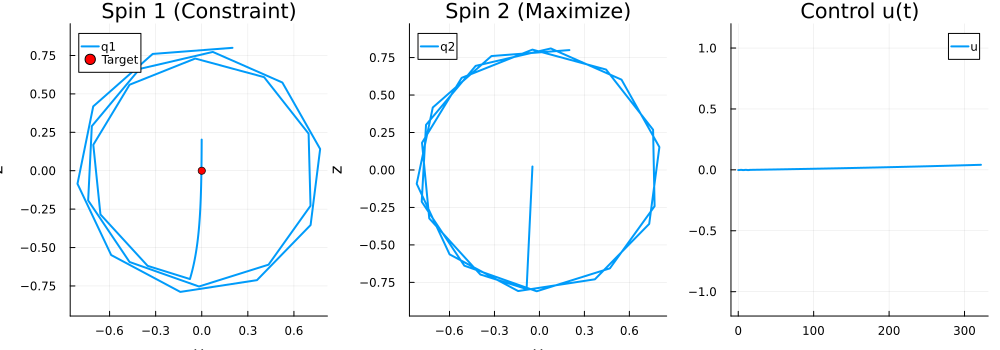

In [ ]:
using JuMP
using Ipopt
using DifferentialEquations
using LinearAlgebra
using Plots

# --- 1. Dinámica del PMP (Estado + Co-estado) ---
function bloch_pmp_dynamics!(du, u_vec, p, t)


    y1, z1, y2, z2 = u_vec[1], u_vec[2], u_vec[3], u_vec[4]
    py1, pz1, py2, pz2 = u_vec[5], u_vec[6], u_vec[7], u_vec[8]
    
    G1, g1, G2, g2 = p

    # Función de conmutación (Switching function)
    # H = p * f(x,u). La parte que depende de u es u * phi
    phi = -py1*z1 + pz1*y1 - py2*z2 + pz2*y2
    
    u_val = if phi > 0
        1.0
    else
        0.0
    end
    # --- Ecuaciones de Estado (Bloch) ---
    # q1
    du[1] = -G1*y1 - u_val*z1       # dy1
    du[2] = g1*(1-z1) + u_val*y1    # dz1
    # q2
    du[3] = -G2*y2 - u_val*z2       # dy2
    du[4] = g2*(1-z2) + u_val*y2    # dz2

    du[5] = G1*py1 - u_val*pz1      # dpy1
    du[6] = pz1*g1 + u_val*py1      # dpz1
    du[7] = G2*py2 - u_val*pz2      # dpy2
    du[8] = pz2*g2 + u_val*py2      # dpz2
end

# --- 2. Helper to get Final State ---
function get_final_state(py1_0, pz1_0, py2_0, pz2_0, tf, params)
    u0 = [0.2, 0.8, 0.2, 0.8, py1_0, pz1_0, py2_0, pz2_0]
    p_ode = [params[1], params[2], params[3], params[4]] # k=20 smoothing
    
    prob = ODEProblem(bloch_pmp_dynamics!, u0, (0.0, tf), p_ode)
    

    sol = solve(prob, Tsit5(), reltol=1e-7, abstol=1e-7, save_everystep=false, verbose=false)
    return sol.u[end]

end

# --- 3. Wrapper Functions for JuMP ---

# Constraint 1: y1(tf) must be 0
function constr_y1(py1, pz1, py2, pz2, tf, c1, c2, c3, c4)
    final = get_final_state(py1, pz1, py2, pz2, tf, [c1,c2,c3,c4])
    return final[1]
end

# Constraint 2: z1(tf) must be 0
function constr_z1(py1, pz1, py2, pz2, tf, c1, c2, c3, c4)
    final = get_final_state(py1, pz1, py2, pz2, tf, [c1,c2,c3,c4])
    return final[2]
end

# Objective Component: Transversality Error for q2
function obj_transversality(py1, pz1, py2, pz2, tf, c1, c2, c3, c4)
    final = get_final_state(py1, pz1, py2, pz2, tf, [c1,c2,c3,c4])
    # Error: p2 - 2*q2
    e3 = final[7] - 2*final[3]
    e4 = final[8] - 2*final[4]
    return e3^2 + e4^2
end

# --- 4. Main Shooting Function ---
function RobustShootingConstrained(tf, v1, v2)
    cons = [v1[1], v1[2], v2[1], v2[2]]
    
    model = JuMP.Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 5)
    set_optimizer_attribute(model, "max_iter", 500)
    # Relax tolerance slightly for difficult shooting problems
    set_optimizer_attribute(model, "acceptable_tol", 1e-3)

    # Decision variables: Initial Costates
    @variable(model, -1 <= p[1:4] <= 1)
    set_start_value.(p, [0.0, 0.0, 0.2, 0.8]) # Initial guess

    # Register functions for JuMP (autodiff=true uses ForwardDiff through ODE)
    register(model, :f_y1, 9, constr_y1, autodiff=true)
    register(model, :f_z1, 9, constr_z1, autodiff=true)
    register(model, :f_obj, 9, obj_transversality, autodiff=true)

    # --- CONSTRAINTS: q1(tf) = 0 ---
    @NLconstraint(model, c_y1, f_y1(p[1], p[2], p[3], p[4], tf, cons[1], cons[2], cons[3], cons[4]) == 0)
    @NLconstraint(model, c_z1, f_z1(p[1], p[2], p[3], p[4], tf, cons[1], cons[2], cons[3], cons[4]) == 0)

    # --- OBJECTIVE: Minimize Transversality Error for q2 ---
    @NLobjective(model, Min, f_obj(p[1], p[2], p[3], p[4], tf, cons[1], cons[2], cons[3], cons[4]))

    println("--> Starting Constrained Shooting Method...")
    optimize!(model)

    # Results
    p_opt = value.(p)
    println("Status: ", termination_status(model))
    println("Optimal Costates p(0): ", p_opt)

    # --- Final Simulation ---
    # Use high k for sharp bang-bang control visualization
    p_sim = [cons[1], cons[2], cons[3], cons[4]]
    u0_sim = [0.2, 0.8, 0.2, 0.8, p_opt[1], p_opt[2], p_opt[3], p_opt[4]]
    
    prob_final = ODEProblem(bloch_pmp_dynamics!, u0_sim, (0.0, tf), p_sim)
    sol = solve(prob_final, Tsit5(), reltol=1e-8, saveat=tf/500)

    println("\n--- Final State Verification ---")
    println("q1(tf): ", sol[end][1:2], " (Should be [0.0, 0.0])")
    println("q2(tf): ", sol[end][3:4], " ")
    println("|q2(tf)|: ", norm(sol[end][3:4]))

    # Plotting
    ts = sol.t
    us = [-u[5]*u[2] + u[6]*u[1] - u[7]*u[4] + u[8]*u[3] for u in sol.u]

    p1 = plot(sol, vars=(1,2), title="Spin 1 (Constraint)", label="q1", xlabel="y", ylabel="z", lw=2, aspect_ratio=:equal)
    scatter!(p1, [0], [0], label="Target", color=:red)
    
    p2 = plot(sol, vars=(3,4), title="Spin 2 (Maximize)", label="q2", xlabel="y", ylabel="z", lw=2, aspect_ratio=:equal)
    
    p3 = plot(ts, us, title="Control u(t)", label="u", linetype=:steppost, ylimits=(-1.2, 1.2), lw=2)

    plot(p1, p2, p3, layout=(1,3), size=(1000, 350))
end

w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] 

q01 = [0.2,0.8]

tf = find_tmin(v1,q01)

RobustShootingConstrained(2*tf, v1, v2)